In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import healpy as hp
from scipy.optimize import curve_fit, minimize

In [3]:
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS

In [4]:
def powerlaw(ells, amp, alpha):
    model = np.zeros(len(ells))
    model[2:] = (ells[2:] / 80.)**alpha
    return amp * model

In [5]:
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

In [7]:
def normed_synch(nu, beta):
    nu0 = 2.3e9
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

In [8]:
def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(2.3e9) / normed_cmb_thermo_units(nu)
    return unit

In [9]:
def power_spectrum_2dmodel(ells, freqs, amp, alpha, beta):
    pcls = powerlaw(ells, amp, alpha)
    sed_scaling = scale_synch(freqs, beta)
    return pcls * sed_scaling[..., np.newaxis]

In [10]:
nside = 128

In [12]:
amp = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5

In [13]:
ells = np.arange(3*nside + 1)
freqs = np.linspace(20, 300, 5)*1.e9

# First fit example. Just directly to power law

In [14]:
# amp map power spectrum

In [15]:
pcls = powerlaw(ells, amp, alpha)

In [16]:
opt_params, covariance = curve_fit(powerlaw, ells, pcls, p0=[1e3, -1])

In [17]:
opt_params

array([1700.,   -3.])

In [18]:
# great

# Fit 2D data (has dimension in ell and frequency)
## here we use minimize but we have to make a residual function and it has a different parameter ordering here

In [34]:
power_spectrum_data = power_spectrum_2dmodel(ells, freqs, amp, alpha, beta)

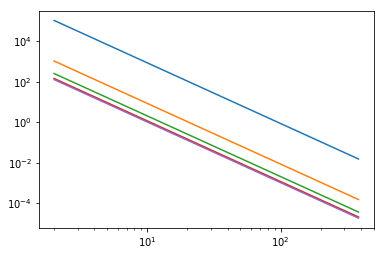

In [35]:
loglog(ells[2:], power_spectrum_data.T[2:]);

In [60]:
def residuals(params, ells, freqs, data):
    amp, alpha, beta = params
    model = power_spectrum_2dmodel(ells, freqs, amp, alpha, beta)
    return np.sum((data - model)**2)

In [61]:
result = minimize(residuals, [1e3, -1, -1], args=(ells, freqs, power_spectrum_data))

In [62]:
result

      fun: 0.06389941073656705
 hess_inv: array([[ 2.03772837e+00,  1.50029028e-05, -5.28444969e-04],
       [ 1.50029028e-05,  1.17215841e-09, -2.12004859e-09],
       [-5.28444969e-04, -2.12004859e-09,  1.40002447e-07]])
      jac: array([ 3.27446908e-02, -3.04982948e+01,  1.23571861e+02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1407
      nit: 157
     njev: 279
   status: 2
  success: False
        x: array([1700.45647598,   -3.00000385,   -3.20013061])

In [63]:
result.x

array([1700.45647598,   -3.00000385,   -3.20013061])

In [64]:
#not bad!